<a href="https://colab.research.google.com/github/nimrashaheen001/Programming_for_AI/blob/main/PRassignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression

# 1. Data Loading and Initial Exploration
# For students: Replace with your dataset or use a similar energy dataset
# Sample datasets: World Bank Open Data, International Energy Agency, Kaggle
def load_data(filepath):
    df = pd.read_csv(filepath)
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    return df

# 2. Data Preprocessing
def preprocess_data(df):
    # Make a copy to avoid modifying original
    df_clean = df.copy()

    # Handle missing values
    missing_percent = df_clean.isnull().mean() * 100

    # Drop columns with more than 30% missing values
    cols_to_drop = missing_percent[missing_percent > 30].index.tolist()
    df_clean = df_clean.drop(columns=cols_to_drop)
    print(f"Dropped columns: {cols_to_drop}")

    # For remaining columns, fill missing values with mean
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if pd.api.types.is_numeric_dtype(df_clean[col]):
                df_clean[col] = df_clean[col].fillna(df_clean[col].mean())

    # Handle categorical variables - convert to numerical
    for col in df_clean.select_dtypes(include=['object']).columns:
        # For simplicity, converting to categorical codes
        # In a real scenario, you might use one-hot encoding or other methods
        df_clean[col] = df_clean[col].astype('category').cat.codes

    return df_clean

# 3. Feature Selection
def select_features(X, y, method='mutual_info', n_features=11):
    if method == 'correlation':
        # Correlation method
        corr_matrix = pd.concat([X, y], axis=1).corr().abs()
        target_corr = corr_matrix[y.name].sort_values(ascending=False)
        selected_features = target_corr.index[1:n_features+1]  # Exclude target itself

    elif method == 'mutual_info':
        # Mutual information method
        mi_scores = mutual_info_regression(X, y)
        mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores})
        mi_df = mi_df.sort_values('MI_Score', ascending=False)
        selected_features = mi_df['Feature'][:n_features].values

    return selected_features

# 4. Model Training and Evaluation
def train_evaluate_model(X_train, X_test, y_train, y_test):
    # Initialize the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)

    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Calculate MAPE
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    print(f"Training MAE: {train_mae:.2f}, R²: {train_r2:.4f}, MAPE: {train_mape:.2f}%")
    print(f"Testing MAE: {test_mae:.2f}, R²: {test_r2:.4f}, MAPE: {test_mape:.2f}%")

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    return rf_model, feature_importance, y_pred_test

# 5. Visualization Functions
def plot_correlation_matrix(df, target_col=None):
    plt.figure(figsize=(12, 10))
    corr_matrix = df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm',
                linewidths=0.5, square=True)

    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

    if target_col:
        plt.figure(figsize=(10, 6))
        corr_with_target = corr_matrix[target_col].sort_values(ascending=False)
        corr_with_target = corr_with_target.drop(target_col)  # Drop self-correlation
        sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
        plt.title(f'Correlation with {target_col}')
        plt.tight_layout()
        plt.show()

def plot_feature_importance(importance_df, top_n=10):
    plt.figure(figsize=(10, 6))
    importance_df.head(top_n).sort_values('Importance').plot(
        kind='barh', x='Feature', y='Importance', legend=False)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

def plot_actual_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)

    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.tight_layout()
    plt.show()

# 6. Main Execution Function
def main():
    # For demonstration - replace with actual data
    # Example: data = load_data('energy_data.csv')

    # Here's how you'd use the functions above:
    # 1. Load and explore data
     data = load_data('global-data-on-sustainable-energy.csv')

    # 2. Preprocess data
    data_clean = preprocess_data(data)

    # 3. Define target and features
    Assuming 'Electricity from renewables (TWh)' is your target column
    target_col = 'Electricity from renewables (TWh)'
    y = data_clean[target_col]
    X = data_clean.drop(columns=[target_col])

    # 4. Visualize correlations
    plot_correlation_matrix(data_clean, target_col)

    # 5. Feature selection
    selected_features = select_features(X, y, method='mutual_info', n_features=11)
    X_selected = X[selected_features]

    # 6. Split data
     X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=42)

    # 7. Train and evaluate model
    model, importance, y_pred = train_evaluate_model(X_train, X_test, y_train, y_test)

    # 8. Visualize results
    plot_feature_importance(importance)
    plot_actual_vs_predicted(y_test, y_pred)

    print("Please modify this code to use your own dataset or a similar energy dataset.")
    print("You'll need to adjust column names and possibly other aspects based on your data.")

if __name__ == "__main__":
    main()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 153)

Dataset shape: (3649, 21)
Columns: ['Entity', 'Year', 'Access to electricity (% of population)', 'Access to clean fuels for cooking', 'Renewable-electricity-generating-capacity-per-capita', 'Financial flows to developing countries (US $)', 'Renewable energy share in the total final energy consumption (%)', 'Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)', 'Electricity from renewables (TWh)', 'Low-carbon electricity (% electricity)', 'Primary energy consumption per capita (kWh/person)', 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)', 'Value_co2_emissions_kt_by_country', 'Renewables (% equivalent primary energy)', 'gdp_growth', 'gdp_per_capita', 'Density\\n(P/Km2)', 'Land Area(Km2)', 'Latitude', 'Longitude']
Dropped columns: ['Financial flows to developing countries (US $)', 'Renewables (% equivalent primary energy)']
                                                      Entity      Year  \
Entity                                              1.000000

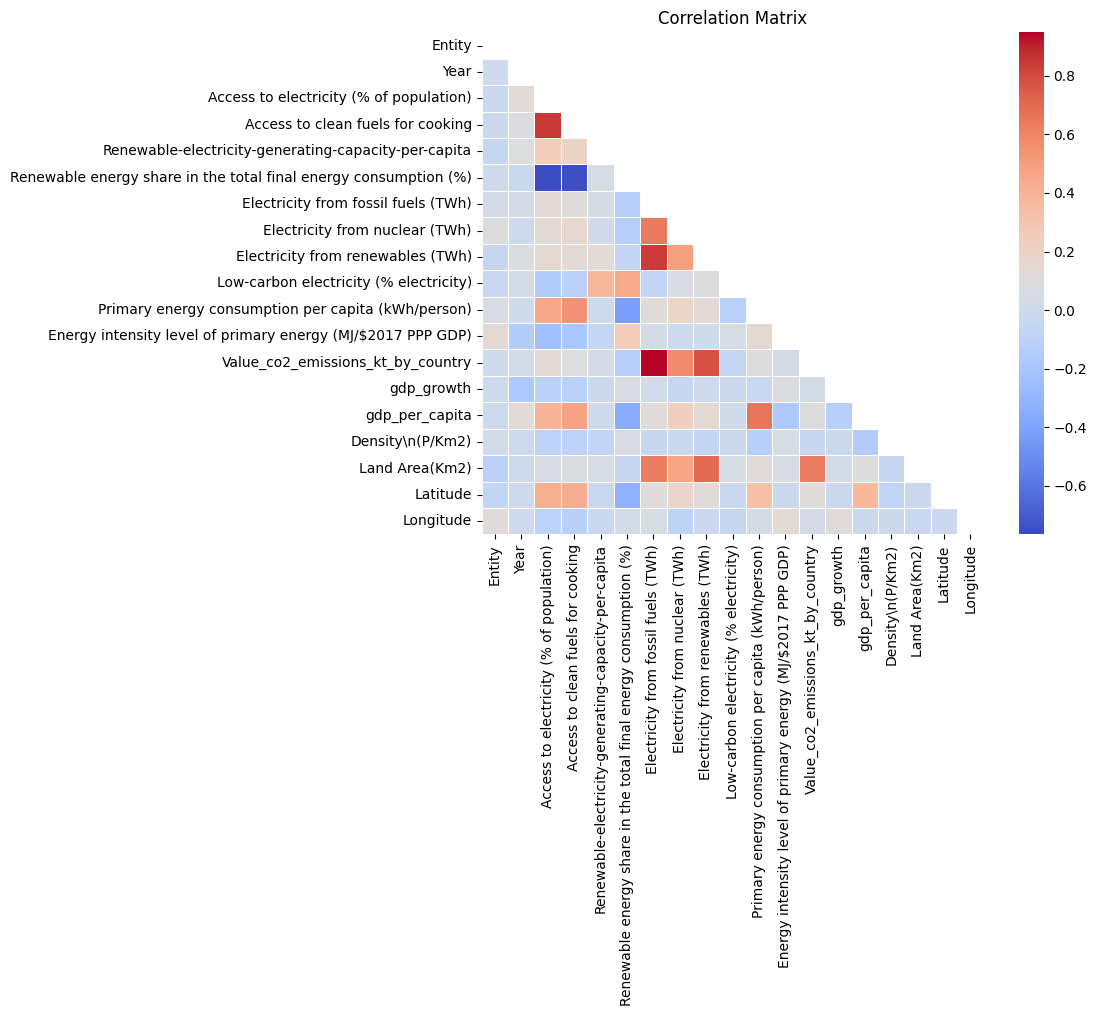

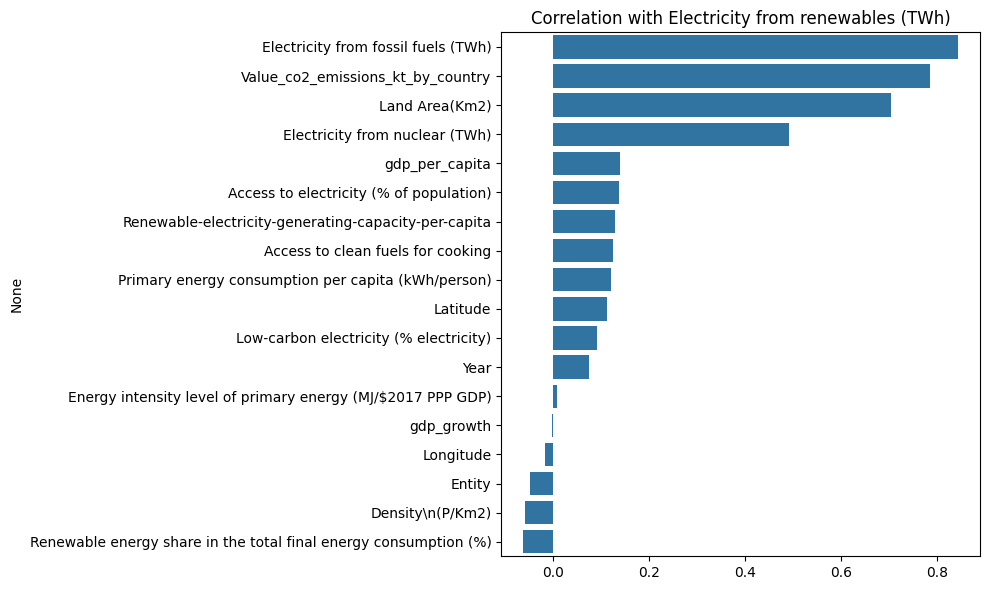

Training MAE: 1.00, R²: 0.9938, MAPE: inf%
Testing MAE: 1.28, R²: 0.9922, MAPE: inf%


<Figure size 1000x600 with 0 Axes>

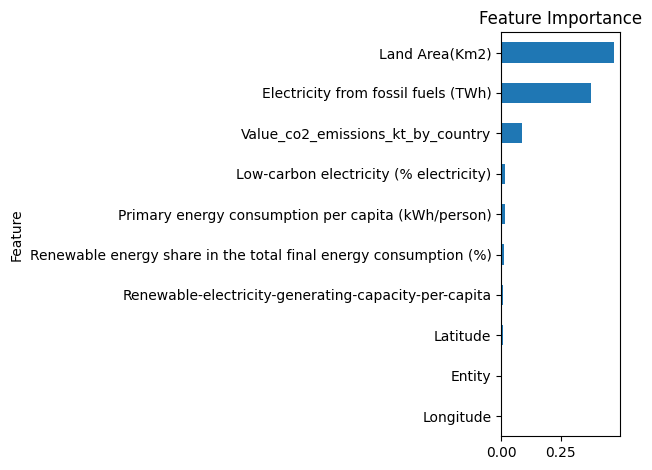

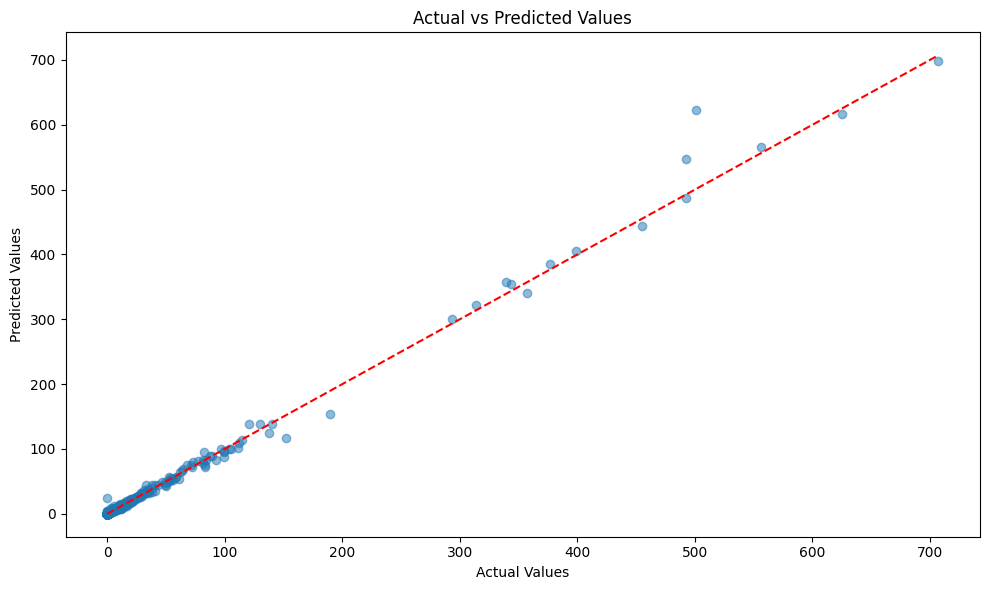

Please modify this code to use your own dataset or a similar energy dataset.
You'll need to adjust column names and possibly other aspects based on your data.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression

# 1. Data Loading and Initial Exploration
# For students: Replace with your dataset or use a similar energy dataset
# Sample datasets: World Bank Open Data, International Energy Agency, Kaggle
def load_data(filepath):
    df = pd.read_csv(filepath)
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    return df

# 2. Data Preprocessing
def preprocess_data(df):
    # Make a copy to avoid modifying original
    df_clean = df.copy()

    # Handle missing values
    missing_percent = df_clean.isnull().mean() * 100

    # Drop columns with more than 30% missing values
    cols_to_drop = missing_percent[missing_percent > 30].index.tolist()
    df_clean = df_clean.drop(columns=cols_to_drop)
    print(f"Dropped columns: {cols_to_drop}")

    # For remaining columns, fill missing values with mean
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if pd.api.types.is_numeric_dtype(df_clean[col]):
                df_clean[col] = df_clean[col].fillna(df_clean[col].mean())

    # Handle categorical variables - convert to numerical
    for col in df_clean.select_dtypes(include=['object']).columns:
        # For simplicity, converting to categorical codes
        # In a real scenario, you might use one-hot encoding or other methods
        df_clean[col] = df_clean[col].astype('category').cat.codes

    return df_clean

# 3. Feature Selection
def select_features(X, y, method='mutual_info', n_features=11):
    if method == 'correlation':
        # Correlation method
        corr_matrix = pd.concat([X, y], axis=1).corr().abs()
        target_corr = corr_matrix[y.name].sort_values(ascending=False)
        selected_features = target_corr.index[1:n_features+1]  # Exclude target itself

    elif method == 'mutual_info':
        # Mutual information method
        mi_scores = mutual_info_regression(X, y)
        mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores})
        mi_df = mi_df.sort_values('MI_Score', ascending=False)
        selected_features = mi_df['Feature'][:n_features].values

    return selected_features

# 4. Model Training and Evaluation
def train_evaluate_model(X_train, X_test, y_train, y_test):
    # Initialize the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)

    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    # Calculate MAPE
    train_mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    print(f"Training MAE: {train_mae:.2f}, R²: {train_r2:.4f}, MAPE: {train_mape:.2f}%")
    print(f"Testing MAE: {test_mae:.2f}, R²: {test_r2:.4f}, MAPE: {test_mape:.2f}%")

    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    return rf_model, feature_importance, y_pred_test

# 5. Visualization Functions
def plot_correlation_matrix(df, target_col=None):
    plt.figure(figsize=(12, 10))
    corr_matrix = df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Display all columns and rows of the correlation matrix
    # Setting display options for pandas to show all columns and rows
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    print(corr_matrix)  # Print the full matrix

    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm',
                linewidths=0.5, square=True)

    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

    if target_col:
        plt.figure(figsize=(10, 6))
        corr_with_target = corr_matrix[target_col].sort_values(ascending=False)
        corr_with_target = corr_with_target.drop(target_col)  # Drop self-correlation
        sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
        plt.title(f'Correlation with {target_col}')
        plt.tight_layout()
        plt.show()

def plot_feature_importance(importance_df, top_n=10):
    plt.figure(figsize=(10, 6))
    importance_df.head(top_n).sort_values('Importance').plot(
        kind='barh', x='Feature', y='Importance', legend=False)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

def plot_actual_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)

    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.tight_layout()
    plt.show()

# 6. Main Execution Function
def main():
    # For demonstration - replace with actual data
    # Example: data = load_data('energy_data.csv')

    # Here's how you'd use the functions above:
    # 1. Load and explore data
    data = load_data('/content/global-data-on-sustainable-energy (1).csv')

    # 2. Preprocess data
    data_clean = preprocess_data(data)

    # 3. Define target and features
    #Assuming 'Electricity from renewables (TWh)' is your target column
    target_col = 'Electricity from renewables (TWh)'
    y = data_clean[target_col]
    X = data_clean.drop(columns=[target_col])

    # 4. Visualize correlations
    plot_correlation_matrix(data_clean, target_col)

    # 5. Feature selection
    selected_features = select_features(X, y, method='mutual_info', n_features=11)
    X_selected = X[selected_features]

    # 6. Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=42)

    # 7. Train and evaluate model
    model, importance, y_pred = train_evaluate_model(X_train, X_test, y_train, y_test)

    # 8. Visualize results
    plot_feature_importance(importance)
    plot_actual_vs_predicted(y_test, y_pred)

    print("Please modify this code to use your own dataset or a similar energy dataset.")
    print("You'll need to adjust column names and possibly other aspects based on your data.")

if __name__ == "__main__":
    main()